We use keras to build our model, first let us import the package

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

C:\Users\HH\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Preparing the Data

This function resizes the images to 64x64. And we use 25000 images of the data as train sample, 12500 images as test sample. I also separated cats and dogs for exploratory analysis.

In [11]:
TRAIN_DIR = './train/train/'
TEST_DIR = './test/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%2500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 25000
Processed 2500 of 25000
Processed 5000 of 25000
Processed 7500 of 25000
Processed 10000 of 25000
Processed 12500 of 25000
Processed 15000 of 25000
Processed 17500 of 25000
Processed 20000 of 25000
Processed 22500 of 25000
Processed 0 of 250
Train shape: (25000, 3, 64, 64)
Test shape: (250, 3, 64, 64)


# Generating the Labels

We're dealing with a binary classification problem here - (1) dog (0) cat. The lables can be created by looping over the file names in the train directory. It's nice to see the training data is perfectly balanced.

Training matrix shape (19999, 3, 64, 64)
Testing matrix shape (250, 3, 64, 64)


Text(0.5,1,'Cats and Dogs')

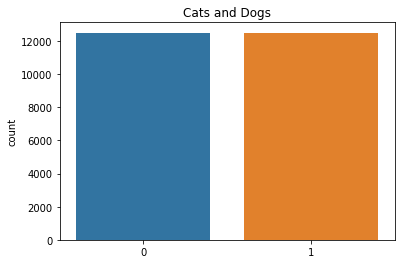

In [12]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)
        
train = train.reshape(-1,3,64,64)
test = test.reshape(-1,3,64,64)

X_train = train.astype('float64')
X_test = test.astype('float64')

X_train /= 255
X_test /= 255
Y_train = labels

X_valid = X_train[:5000, :, :, :]
Y_valid =   Y_train[:5000]
X_train = X_train[5001:25000, :, :, :]
Y_train  = Y_train[5001:25000]

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)
        
        
sns.countplot(labels)
plt.title('Cats and Dogs')

# Checking out Cats and Dogs

A quick side-by-side comparison of the animals.

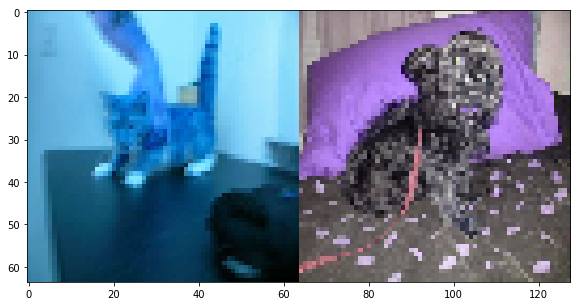

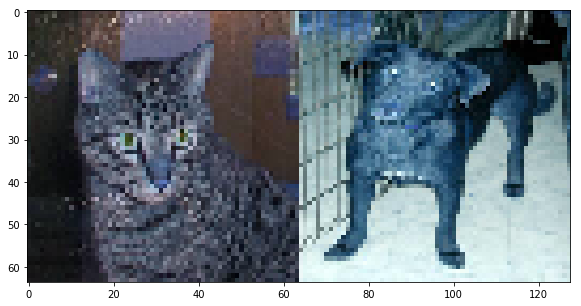

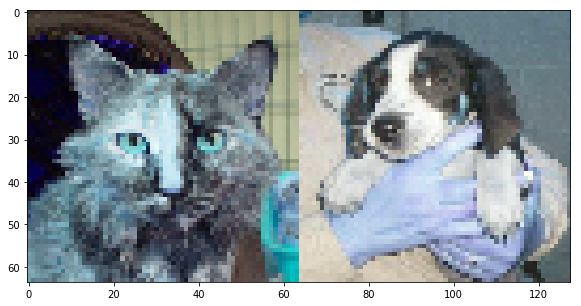

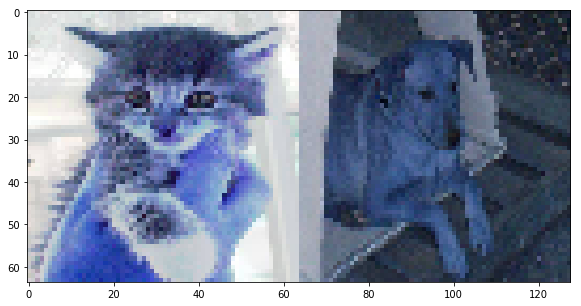

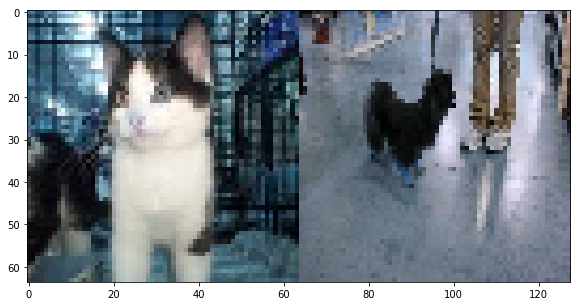

In [4]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

# Build the model

A scaled down version of the VGG-16, with a few notable changes.

Number of convolution filters cut in half, fully connected (dense) layers scaled down.

Set RMSprop as the optimizer.

Set binary_crossentropy as the loss function.

Set sigmoid as the activation function.

In [8]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()
model.summary()

C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(3, 64, 64..., activation="relu", padding="same")`
  if __name__ == '__main__':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 3, 64, 32)         18464     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 64, 32)         9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 32, 32)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 32, 64)         18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 32, 64)         36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 16, 64)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 16, 128)        73856     
__________

# Train

Set the epoch number to be 8 and batch size 128

In [9]:
model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 4,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/4
19999/19999 [==============================] - 154s 8ms/step - loss: 0.6624 - acc: 0.6231 - val_loss: 0.9161 - val_acc: 0.0000e+00
Epoch 2/4
19999/19999 [==============================] - 159s 8ms/step - loss: 0.6372 - acc: 0.6373 - val_loss: 0.8059 - val_acc: 0.4256
Epoch 3/4
19999/19999 [==============================] - 157s 8ms/step - loss: 0.6208 - acc: 0.6611 - val_loss: 0.7199 - val_acc: 0.5240
Epoch 4/4
19999/19999 [==============================] - 159s 8ms/step - loss: 0.6087 - acc: 0.6696 - val_loss: 0.4326 - val_acc: 0.8780


The final accuracy is 0.87

This result is not very well. Then we try to change some parameters to see the diffrerence

# Change the pixel of dataset

Resizes the images to 32x32 and change the channels to be 1

In [10]:
TRAIN_DIR = './train/train/'
TEST_DIR = './test/test/'


ROWS = 32
COLS = 32
CHANNELS = 1

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%2500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)
        
train = train.reshape(-1, 32,32,1)
test = test.reshape(-1, 32,32,1)
X_train = train.astype('float32')
X_test = test.astype('float32')
X_train /= 255
X_test /= 255
Y_train=labels

X_valid = X_train[:5000,:,:,:]
Y_valid =   Y_train[:5000]
X_train = X_train[5001:25000,:,:,:]
Y_train  = Y_train[5001:25000]

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Processed 0 of 25000
Processed 2500 of 25000
Processed 5000 of 25000
Processed 7500 of 25000
Processed 10000 of 25000
Processed 12500 of 25000
Processed 15000 of 25000
Processed 17500 of 25000
Processed 20000 of 25000
Processed 22500 of 25000
Processed 0 of 250
Train shape: (25000, 1, 32, 32)
Test shape: (250, 1, 32, 32)
Training matrix shape (19999, 32, 32, 1)
Testing matrix shape (250, 32, 32, 1)


In [13]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

def catdog():
    
    model = Sequential()

    model.add(Convolution2D(16, 3, 3, border_mode='same', input_shape=(ROWS, COLS, CHANNELS), activation='relu'))
    model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(32, 32, 1..., activation="relu", padding="same")`
  
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same")`
  if __name__ == '__main__':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  if sys.path[0] == '':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same

In [14]:
model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 4,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/4
19999/19999 [==============================] - 94s 5ms/step - loss: 0.6579 - acc: 0.6248 - val_loss: 1.0077 - val_acc: 6.0000e-04
Epoch 2/4
19999/19999 [==============================] - 95s 5ms/step - loss: 0.6386 - acc: 0.6418 - val_loss: 1.0348 - val_acc: 0.1820
Epoch 3/4
19999/19999 [==============================] - 96s 5ms/step - loss: 0.6268 - acc: 0.6579 - val_loss: 1.0310 - val_acc: 0.1838
Epoch 4/4
19999/19999 [==============================] - 95s 5ms/step - loss: 0.6144 - acc: 0.6679 - val_loss: 0.5029 - val_acc: 0.8182


The train accuracy and test accuracy both lower

Resizes the images to 256x256 and change the channels to be 3

In [6]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [2]:
import os, cv2, random
import numpy as np
import pandas as pd

TRAIN_DIR = './train/train/'
TEST_DIR = './test/test/'

ROWS = 256
COLS = 256
ROWS2 = 64
COLS2 = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:10000] + train_cats[:10000]
random.shuffle(train_images)
test_images =  test_images[:250]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS2, COLS2), interpolation=cv2.INTER_CUBIC)

def read_image2(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS2, COLS2), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%2500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

def prep_data2(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image2(image_file)
        data[i] = image.T
        if i%100 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)
test2 = prep_data2(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 20000
Processed 2500 of 20000
Processed 5000 of 20000
Processed 7500 of 20000
Processed 10000 of 20000
Processed 12500 of 20000
Processed 15000 of 20000
Processed 17500 of 20000
Processed 0 of 250
Processed 0 of 250
Processed 100 of 250
Processed 200 of 250
Train shape: (20000, 3, 64, 64)
Test shape: (250, 3, 64, 64)


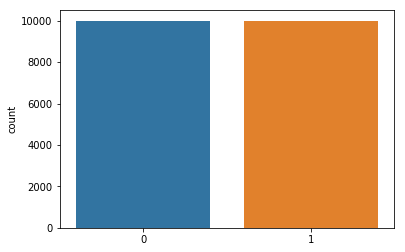

In [7]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)

In [3]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape=train.shape[1:], activation='relu'))
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("First layer...")
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Second layer...")
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Third layer...")
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #print("Flattening, etc...")
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    print("Compiling model...")
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

print("Creating model:")
model = catdog()

C:\Users\HH\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Creating model:
Compiling model...


running model...
Train on 15000 samples, validate on 5000 samples
Epoch 1/4
 - 155s - loss: 2.2850 - acc: 0.5029 - val_loss: 7.9552 - val_acc: 0.4658
Epoch 2/4
 - 159s - loss: 7.8637 - acc: 0.5083 - val_loss: 7.9785 - val_acc: 0.5050
Epoch 3/4
 - 162s - loss: 8.1218 - acc: 0.4949 - val_loss: 7.9785 - val_acc: 0.5050
Epoch 4/4
 - 160s - loss: 8.0103 - acc: 0.5021 - val_loss: 7.9785 - val_acc: 0.5050
Epoch 00004: early stopping
making predictions on test set...


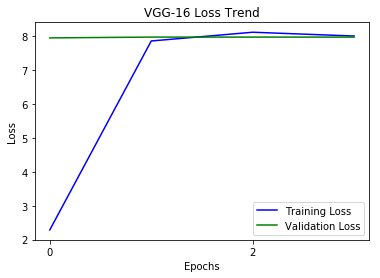

In [9]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

epochs =4
batch_size = 128

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
       

def run_catdog():
    
    history = LossHistory()
    print("running model...")
    model.fit(train, labels, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=2, shuffle=True, callbacks=[history, early_stopping])
    
    print("making predictions on test set...")
    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

loss = history.losses
val_loss = history.val_losses


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

The train accuracy and test accuracy both become much lower.

So the best size should be 64*64.

# Change Activation Function

Change Activation Function from 'relu' to 'sigmoid'

A wide variety of sigmoid functions have been used as the activation function of artificial neurons, including the logistic and hyperbolic tangent functions. Sigmoid curves are also common in statistics as cumulative distribution functions (which go from 0 to 1), such as the integrals of the logistic distribution, the normal distribution, and Student's t probability density functions.

So we want to try sigmoid function to increase the accuracy

In [13]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(3, 64, 64..., activation="relu", padding="same")`
  if __name__ == '__main__':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), 

In [14]:
model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 4,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/4
19999/19999 [==============================] - 143s 7ms/step - loss: 0.7059 - acc: 0.5787 - val_loss: 0.9101 - val_acc: 0.0516
Epoch 2/4
19999/19999 [==============================] - 144s 7ms/step - loss: 0.6975 - acc: 0.5814 - val_loss: 0.9933 - val_acc: 0.0000e+00
Epoch 3/4
19999/19999 [==============================] - 147s 7ms/step - loss: 0.6963 - acc: 0.5844 - val_loss: 1.0234 - val_acc: 0.0000e+00
Epoch 4/4
19999/19999 [==============================] - 145s 7ms/step - loss: 0.6879 - acc: 0.5912 - val_loss: 1.0297 - val_acc: 0.0000e+00


The accuracy is very low so we still use relu as activation function

# Change the loss function

Change the loss function from 'binary_crossentropy' to 'mean_squared_error'.

Mean squared error measures the average of the squares of the errors or deviations—that is, the difference between the estimator and what is estimated. MSE is a risk function, corresponding to the expected value of the squared error loss or quadratic loss. The difference occurs because of randomness or because the estimator doesn't account for information that could produce a more accurate estimate.

In [15]:
optimizer = RMSprop(lr=1e-4)


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


model = catdog()

C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(3, 64, 64..., activation="relu", padding="same")`
  
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  if __name__ == '__main__':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  if sys.path[0] == '':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="sam

In [16]:
model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 4,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/4
19999/19999 [==============================] - 155s 8ms/step - loss: 0.2349 - val_loss: 0.3816
Epoch 2/4
19999/19999 [==============================] - 148s 7ms/step - loss: 0.2268 - val_loss: 0.3935
Epoch 3/4
19999/19999 [==============================] - 147s 7ms/step - loss: 0.2192 - val_loss: 0.6462
Epoch 4/4
19999/19999 [==============================] - 153s 8ms/step - loss: 0.2170 - val_loss: 0.3722


mean_squared_error is also not suitable

binary_crossentropy means Logarithmic Loss, or simply Log Loss, is a classification loss function often used as an evaluation metric in kaggle competitions. Since success in these competitions hinges on effectively minimising the Log Loss, it makes sense to have some understanding of how this metric is calculated and how it should be interpreted.

Our project is to do classfiction so binary_crossentropy should be the best choice

# Change the optimizer

Change the optimizer from 'RMSprop' to 'adam'

RMSprop is an unpublished, adaptive learning rate method proposed by Geoff Hinton in Lecture 6e of his Coursera Class.

RMSprop and Adadelta have both been developed independently around the same time stemming from the need to resolve Adagrad's radically diminishing learning rates. 

Adaptive Moment Estimation (Adam) is another method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients vt like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients mt, similar to momentum. Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, which thus prefers flat minima in the error surface. 

In [17]:
optimizer = 'adam'
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer='adam', metrics=['accuracy'])
    return model


model = catdog()

C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(3, 64, 64..., activation="relu", padding="same")`
  if __name__ == '__main__':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), 

In [18]:
model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 4,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/4
19999/19999 [==============================] - 170s 9ms/step - loss: 0.6657 - acc: 0.6234 - val_loss: 0.9516 - val_acc: 0.0000e+00
Epoch 2/4
19999/19999 [==============================] - 166s 8ms/step - loss: 0.6577 - acc: 0.6305 - val_loss: 0.9355 - val_acc: 0.0116
Epoch 3/4
19999/19999 [==============================] - 166s 8ms/step - loss: 0.6455 - acc: 0.6401 - val_loss: 0.8692 - val_acc: 0.2364
Epoch 4/4
19999/19999 [==============================] - 168s 8ms/step - loss: 0.6342 - acc: 0.6455 - val_loss: 0.8502 - val_acc: 0.1952


RMSprop is better than adam, so we will choose RMSprop in our best model

# Change network

Change the network frim CNN to LSTM

In [41]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [43]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(3, 64, 64..., activation="relu", padding="same")`
  if __name__ == '__main__':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), 

In [44]:
model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 8,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/8
19999/19999 [==============================] - 136s 7ms/step - loss: 0.7144 - acc: 0.5750 - val_loss: 1.0166 - val_acc: 0.0000e+00
Epoch 2/8
19999/19999 [==============================] - 134s 7ms/step - loss: 0.7055 - acc: 0.5764 - val_loss: 1.0883 - val_acc: 0.0000e+00
Epoch 3/8
19999/19999 [==============================] - 135s 7ms/step - loss: 0.6969 - acc: 0.5828 - val_loss: 1.0115 - val_acc: 0.0000e+00
Epoch 4/8
19999/19999 [==============================] - 136s 7ms/step - loss: 0.6919 - acc: 0.5889 - val_loss: 0.9983 - val_acc: 0.0000e+00
Epoch 5/8
19999/19999 [==============================] - 136s 7ms/step - loss: 0.6860 - acc: 0.5952 - val_loss: 0.9644 - val_acc: 0.0000e+00
Epoch 6/8
19999/19999 [==============================] - 137s 7ms/step - loss: 0.6841 - acc: 0.5947 - val_loss: 0.9748 - val_acc: 0.0000e+00
Epoch 7/8
19999/19999 [==============================] - 135s 7ms/step - loss: 0.6794 - acc: 0.6025 - val

# Change the kernel initalizer

Change the kernel_initializer as 'random_uniform'

In [19]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64,kernel_initializer='random_uniform',bias_initializer='zeros'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(3, 64, 64..., activation="relu", padding="same")`
  if __name__ == '__main__':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), 

In [20]:
model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 4,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/4
19999/19999 [==============================] - 165s 8ms/step - loss: 0.6610 - acc: 0.6246 - val_loss: 0.9473 - val_acc: 0.0000e+00
Epoch 2/4
19999/19999 [==============================] - 163s 8ms/step - loss: 0.6467 - acc: 0.6317 - val_loss: 0.6199 - val_acc: 0.8130
Epoch 3/4
19999/19999 [==============================] - 164s 8ms/step - loss: 0.6232 - acc: 0.6554 - val_loss: 1.2812 - val_acc: 0.2026
Epoch 4/4
19999/19999 [==============================] - 160s 8ms/step - loss: 0.6068 - acc: 0.6696 - val_loss: 1.3686 - val_acc: 0.1792


We get a very low test accuracy

# Change the convolution filters number

Reduce the convolution filters numbers and see the change

In [23]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [24]:
TRAIN_DIR = './train/train/'
TEST_DIR  = './test/test/'

ROWS = 32
COLS = 32
CHANNELS = 1

train_images = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
test_images =  [TEST_DIR + i for i in os.listdir(TEST_DIR)]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i % 2500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 25000
Processed 2500 of 25000
Processed 5000 of 25000
Processed 7500 of 25000
Processed 10000 of 25000
Processed 12500 of 25000
Processed 15000 of 25000
Processed 17500 of 25000
Processed 20000 of 25000
Processed 22500 of 25000
Processed 0 of 250
Train shape: (25000, 1, 32, 32)
Test shape: (250, 1, 32, 32)


In [25]:
labels = []

for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

train = train.reshape(-1, 32,32,1)
test = test.reshape(-1, 32,32,1)

X_train = train.astype('float32')
X_test = test.astype('float32')

X_train /= 255
X_test /= 255
Y_train = labels

X_valid = X_train[:5000, :, :, :]
Y_valid =   Y_train[:5000]
X_train = X_train[5001:25000, :, :, :]
Y_train  = Y_train[5001:25000]

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (19999, 32, 32, 1)
Testing matrix shape (250, 32, 32, 1)


In [26]:
def CatDog():
    
    #Neural network model object
    model = Sequential()
    
    #First convolution
    model.add(Convolution2D(
        16, 3, 3,
        border_mode = 'same',
        input_shape = (ROWS, COLS, CHANNELS),
        activation = 'relu'
    ))
    
    #First dimensionality reduction
    model.add(
        MaxPooling2D( pool_size = (2, 2) )
    )
    
    #Second convolution
    model.add(Convolution2D(
        32, 3, 3,
        border_mode = 'same',
        activation = 'relu'
    ))
    
    #Second dimensionality reduction
    model.add(
        MaxPooling2D( pool_size = (2, 2) )
    )
    
    #Dimensionality reduction to single array
    model.add(Flatten())
    
    #Dense layers - linear model on flattened array
    model.add(Dense(100, activation = 'relu'))
    
    #Prevent overfitting by randomly setting some model coeffecients to zero
    model.add(Dropout(0.5))
    
    #More dense layers
    model.add(Dense(100, activation = 'relu'))
    
    #More overfitting prevention
    model.add(Dropout(0.5))
    
    #Last dense layer
    model.add(Dense(1))
    
    #Add output to model
    model.add(Activation('sigmoid'))
    
    #Compile model and return
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics=['accuracy']
    )
    
    return model

model = CatDog()

C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(32, 32, 1..., activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`


In [27]:
model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 4,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/4
19999/19999 [==============================] - 18s 924us/step - loss: 0.6438 - acc: 0.6265 - val_loss: 0.9786 - val_acc: 0.1684
Epoch 2/4
19999/19999 [==============================] - 17s 861us/step - loss: 0.5922 - acc: 0.6846 - val_loss: 0.9084 - val_acc: 0.4268928 - acc: 0.68
Epoch 3/4
19999/19999 [==============================] - 17s 851us/step - loss: 0.5534 - acc: 0.7195 - val_loss: 0.9302 - val_acc: 0.4132
Epoch 4/4
19999/19999 [==============================] - 17s 840us/step - loss: 0.5162 - acc: 0.7472 - val_loss: 0.9125 - val_acc: 0.4594 ETA: 2s 


We find the train accuracy is increased and convolution speed faster

Increase the convolution filters numbers and see the change

In [28]:
optimizer = 'adam'
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(16, 3, 3, border_mode='same', input_shape=(ROWS, COLS, CHANNELS), activation='relu'))
    model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(32, 32, 1..., activation="relu", padding="same")`
  if __name__ == '__main__':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), a

In [29]:
nb_epoch = 4
batch_size = 128      
        
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_valid, Y_valid))
    

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/4
19999/19999 [==============================] - 369s 18ms/step - loss: 0.6661 - acc: 0.6231 - val_loss: 0.9440 - val_acc: 0.0000e+00
Epoch 2/4
19999/19999 [==============================] - 350s 18ms/step - loss: 0.6626 - acc: 0.6250 - val_loss: 0.9387 - val_acc: 0.0000e+00
Epoch 3/4
19999/19999 [==============================] - 350s 18ms/step - loss: 0.6622 - acc: 0.6250 - val_loss: 0.9745 - val_acc: 0.0000e+00
Epoch 4/4
19999/19999 [==============================] - 352s 18ms/step - loss: 0.6621 - acc: 0.6250 - val_loss: 0.9852 - val_acc: 0.0000e+00


The test accuracy is very low and the convolution speed is too slow, but the train accuracy is high

# Find the best epochs number

Finally we get two models, one is 32*32 with 4 convolution filters and adam as optimizer

The other is 64*64 with 8 convolution filters and RMSprop as optimizer

We use the 4 epochs before. In fact we don't know the best number of epochs so we set 50 epochs to see the tendency of the train accuracy.

In [2]:
TRAIN_DIR = './train/train/'
TEST_DIR = './test/test/'


ROWS = 32
COLS = 32
CHANNELS = 1

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%2500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)
        
train = train.reshape(-1, 32,32,1)
test = test.reshape(-1, 32,32,1)
X_train = train.astype('float32')
X_test = test.astype('float32')
X_train /= 255
X_test /= 255
Y_train=labels

X_valid = X_train[:5000,:,:,:]
Y_valid =   Y_train[:5000]
X_train = X_train[5001:25000,:,:,:]
Y_train  = Y_train[5001:25000]

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Processed 0 of 25000
Processed 2500 of 25000
Processed 5000 of 25000
Processed 7500 of 25000
Processed 10000 of 25000
Processed 12500 of 25000
Processed 15000 of 25000
Processed 17500 of 25000
Processed 20000 of 25000
Processed 22500 of 25000
Processed 0 of 5000
Processed 2500 of 5000
Train shape: (25000, 1, 32, 32)
Test shape: (5000, 1, 32, 32)
Training matrix shape (19999, 32, 32, 1)
Testing matrix shape (5000, 32, 32, 1)


In [3]:
optimizer = 'adam'
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(16, 3, 3, border_mode='same', input_shape=(ROWS, COLS, CHANNELS), activation='relu'))
    model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    #model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(1, 1)))
    
    #model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    #model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(1, 1)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(32, 32, 1..., activation="relu", padding="same")`
  if __name__ == '__main__':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  


In [43]:
model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 80,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/80
19999/19999 [==============================] - 37s 2ms/step - loss: 0.6420 - acc: 0.6296 - val_loss: 0.8201 - val_acc: 0.3502
Epoch 2/80
19999/19999 [==============================] - 36s 2ms/step - loss: 0.5837 - acc: 0.6909 - val_loss: 0.6859 - val_acc: 0.6806
Epoch 3/80
19999/19999 [==============================] - 37s 2ms/step - loss: 0.5274 - acc: 0.7385 - val_loss: 0.9516 - val_acc: 0.4804
Epoch 4/80
19999/19999 [==============================] - 38s 2ms/step - loss: 0.4979 - acc: 0.7624 - val_loss: 0.7965 - val_acc: 0.5690
Epoch 5/80
19999/19999 [==============================] - 38s 2ms/step - loss: 0.4744 - acc: 0.7779 - val_loss: 0.5656 - val_acc: 0.7122
Epoch 6/80
19999/19999 [==============================] - 38s 2ms/step - loss: 0.4560 - acc: 0.7922 - val_loss: 0.6333 - val_acc: 0.6678
Epoch 7/80
19999/19999 [==============================] - 38s 2ms/step - loss: 0.4268 - acc: 0.8063 - val_loss: 0.6036 - val_acc:

19999/19999 [==============================] - 38s 2ms/step - loss: 0.0481 - acc: 0.9827 - val_loss: 2.1721 - val_acc: 0.6782
Epoch 61/80
19999/19999 [==============================] - 37s 2ms/step - loss: 0.0480 - acc: 0.9830 - val_loss: 1.8946 - val_acc: 0.7048
Epoch 62/80
19999/19999 [==============================] - 38s 2ms/step - loss: 0.0392 - acc: 0.9864 - val_loss: 2.6485 - val_acc: 0.6430
Epoch 63/80
19999/19999 [==============================] - 38s 2ms/step - loss: 0.0382 - acc: 0.9870 - val_loss: 1.9905 - val_acc: 0.7090
Epoch 64/80
19999/19999 [==============================] - 38s 2ms/step - loss: 0.0428 - acc: 0.9847 - val_loss: 2.7508 - val_acc: 0.6320
Epoch 65/80
19999/19999 [==============================] - 37s 2ms/step - loss: 0.0475 - acc: 0.9828 - val_loss: 1.4467 - val_acc: 0.7500
Epoch 66/80
19999/19999 [==============================] - 38s 2ms/step - loss: 0.0440 - acc: 0.9839 - val_loss: 1.9036 - val_acc: 0.7018
Epoch 67/80
19999/19999 [=====================

![accuracy](accuracy.png)

So we think this model's best epochs number should be 30

In [5]:
model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 30,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/30
19999/19999 [==============================] - 48s 2ms/step - loss: 0.6527 - acc: 0.6296 - val_loss: 0.7837 - val_acc: 0.3886
Epoch 2/30
19999/19999 [==============================] - 55s 3ms/step - loss: 0.5957 - acc: 0.6807 - val_loss: 0.9758 - val_acc: 0.3504
Epoch 3/30
19999/19999 [==============================] - 53s 3ms/step - loss: 0.5457 - acc: 0.7250 - val_loss: 1.2190 - val_acc: 0.2888
Epoch 4/30
19999/19999 [==============================] - 57s 3ms/step - loss: 0.5072 - acc: 0.7527 - val_loss: 0.6669 - val_acc: 0.6546
Epoch 5/30
19999/19999 [==============================] - 59s 3ms/step - loss: 0.4639 - acc: 0.7854 - val_loss: 0.6653 - val_acc: 0.6352
Epoch 6/30
19999/19999 [==============================] - 53s 3ms/step - loss: 0.4417 - acc: 0.8002 - val_loss: 0.7753 - val_acc: 0.5796
Epoch 7/30
19999/19999 [==============================] - 51s 3ms/step - loss: 0.4095 - acc: 0.8175 - val_loss: 0.5645 - val_acc:

The train accuracy is 0.97 and the test accuracy is 0.73 

In [6]:
TRAIN_DIR = './train/train/'
TEST_DIR = './test/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%2500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 25000
Processed 2500 of 25000
Processed 5000 of 25000
Processed 7500 of 25000
Processed 10000 of 25000
Processed 12500 of 25000
Processed 15000 of 25000
Processed 17500 of 25000
Processed 20000 of 25000
Processed 22500 of 25000
Processed 0 of 5000
Processed 2500 of 5000
Train shape: (25000, 3, 64, 64)
Test shape: (5000, 3, 64, 64)


Training matrix shape (19999, 3, 64, 64)
Testing matrix shape (5000, 3, 64, 64)


Text(0.5,1,'Cats and Dogs')

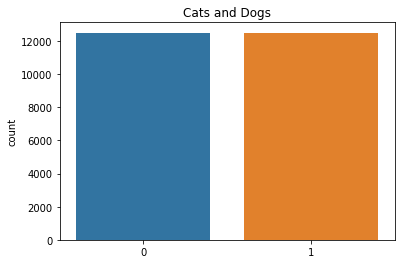

In [7]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)
        
train = train.reshape(-1,3,64,64)
test = test.reshape(-1,3,64,64)

X_train = train.astype('float64')
X_test = test.astype('float64')

X_train /= 255
X_test /= 255
Y_train = labels

X_valid = X_train[:5000, :, :, :]
Y_valid =   Y_train[:5000]
X_train = X_train[5001:25000, :, :, :]
Y_train  = Y_train[5001:25000]

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)
        
        
sns.countplot(labels)
plt.title('Cats and Dogs')

In [8]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(3, 64, 64..., activation="relu", padding="same")`
  if __name__ == '__main__':
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
C:\Users\HH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), 

In [47]:
history = model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 80,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/80
19999/19999 [==============================] - 121s 6ms/step - loss: 0.6621 - acc: 0.6236 - val_loss: 0.8275 - val_acc: 0.0042
Epoch 2/80
19999/19999 [==============================] - 125s 6ms/step - loss: 0.6392 - acc: 0.6433 - val_loss: 1.1933 - val_acc: 0.0500
Epoch 3/80
19999/19999 [==============================] - 128s 6ms/step - loss: 0.6256 - acc: 0.6563 - val_loss: 0.6676 - val_acc: 0.5638
Epoch 4/80
19999/19999 [==============================] - 128s 6ms/step - loss: 0.6192 - acc: 0.6638 - val_loss: 0.7529 - val_acc: 0.3634
Epoch 5/80
19999/19999 [==============================] - 128s 6ms/step - loss: 0.6168 - acc: 0.6666 - val_loss: 0.6556 - val_acc: 0.5926
Epoch 6/80
19999/19999 [==============================] - 128s 6ms/step - loss: 0.6179 - acc: 0.6627 - val_loss: 0.7957 - val_acc: 0.3990
Epoch 7/80
19999/19999 [==============================] - 128s 6ms/step - loss: 0.6194 - acc: 0.6629 - val_loss: 0.7182 - v

![accuracy](accuracy2.png)

We think the best number should be around 24

In [9]:
history = model.fit(
    X_train,
    Y_train,
    batch_size = 128,
    nb_epoch = 24,
    verbose = 1,
    validation_data = (X_valid, Y_valid)
)

C:\Users\HH\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19999 samples, validate on 5000 samples
Epoch 1/24
19999/19999 [==============================] - 150s 7ms/step - loss: 0.6615 - acc: 0.6240 - val_loss: 0.9149 - val_acc: 0.0000e+00
Epoch 2/24
19999/19999 [==============================] - 155s 8ms/step - loss: 0.6399 - acc: 0.6445 - val_loss: 0.7042 - val_acc: 0.5158
Epoch 3/24
19999/19999 [==============================] - 165s 8ms/step - loss: 0.6182 - acc: 0.6636 - val_loss: 0.8994 - val_acc: 0.1970
Epoch 4/24
19999/19999 [==============================] - 155s 8ms/step - loss: 0.6034 - acc: 0.6773 - val_loss: 1.2245 - val_acc: 0.2032
Epoch 5/24
19999/19999 [==============================] - 157s 8ms/step - loss: 0.5971 - acc: 0.6827 - val_loss: 0.9401 - val_acc: 0.4422
Epoch 6/24
19999/19999 [==============================] - 156s 8ms/step - loss: 0.5951 - acc: 0.6812 - val_loss: 0.5929 - val_acc: 0.7174
Epoch 7/24
19999/19999 [==============================] - 167s 8ms/step - loss: 0.5903 - acc: 0.6864 - val_loss: 0.8951